# Spotify Playlist Prediction (ML)

## _Project Overview_

Over the years, there has been a transition on how music lovers access music due to digitalization in the industry. Different mediums have been use to record music trailing back to vinyl records, cassettes, CDs, etc. Now with streaming platforms/apps as the primary model for streaming music, understanding our musical preferences becomes possible with the data at hand.

Therefore as a music ethusiast that regularly listens to many genres from different eras, two distinct playlists were curated on whether the songs were liked or disliked. The goal would be to identify key features through exploratory analysis and develop a model to predict and classify the songs relative to their target playlist. The pool of songs used for this analysis were sourced from recommended playlists of friends and extracted using the Spotify API.

#### _Import Packages_

In [1]:
import pandas as pd
import numpy as np
import math as m
from datetime import datetime
from scipy import stats
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#### _Spotify API Access_

In [2]:
# credientals are hidden for confidentiality
My_Client_ID = mcid
My_Client_Secret_ID = mcsid

User = "jokonkwo"

client_credentials_manager = SpotifyClientCredentials(mcid, mcsid)

spotify = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

####  *Added Functions*

In [3]:
#show all columns in .head()
pd.set_option('display.max_columns', None)

#rename columns
def rename_feat(dataframe, feature, new):
    dataframe = dataframe.rename(columns = {feature:new})
    return dataframe;

#get all songs in playlist (>100 limit)
def get_playlist_tracks(username, playlist_id):
    results = spotify.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    while results['next']:
        results = spotify.next(results)
        tracks.extend(results['items'])
    return tracks;

#one-hot encoding
def onehot(dataframe, feature):
    dataframe = pd.get_dummies(dataframe, columns = [feature])
    return dataframe;

## *Data Processing*

#### _Extract Playlist from User Account_

In [4]:
#Get User Playlists
ALL_playlists = spotify.user_playlists("jokonkwo")

In [5]:
#Create dataframe of playslists (name, track total, playlist id)
playlists = ALL_playlists['items']
jokonkwo_playlists = []
for x in playlists:
    jokonkwo_playlists.append(((x["name"], 
                                x["tracks"]["total"], 
                                x["id"])))
jokonkwo_df = pd.DataFrame(jokonkwo_playlists)
jokonkwo_df = jokonkwo_df.rename(columns = {0: 'playlist name', 
                                            1: 'count', 
                                            2: 'playlist id'})

In [6]:
#Get playlist id (yes/no playlists)
no_pid = jokonkwo_df.loc[jokonkwo_df['playlist name'] == 'DS - LIKE SONG - NO', 'playlist id'].values.item()
yes_pid = jokonkwo_df.loc[jokonkwo_df['playlist name'] == 'DS - LIKE SONG - YES', 'playlist id'].values.item()

###### Song Extraction

In [7]:
#Define playlist dictionaries
YES_playlist = spotify.playlist(yes_pid)
NO_playlist = spotify.playlist(no_pid)

In [8]:
#Extract track dictionary from playlists
YES_songs = get_playlist_tracks('jokonkwo', yes_pid)
NO_songs = get_playlist_tracks('jokonkwo', no_pid)

#Note: get_playlist_tracks() allows an accumulation of tracks to be extracted over the set limit of 100 tracks*

In [9]:
#Create lists (track name/id, artist name/id)
Yes_list = []
for yes in YES_songs:
    Yes_list.append((yes['track']['name'], 
                     yes['track']['id'], 
                     yes['track']['artists'][0]['name'], 
                     yes['track']['artists'][0]['id']))

No_list = []
for no in NO_songs:
    No_list.append((no['track']['name'], 
                    no['track']['id'], 
                    no['track']['artists'][0]['name'], 
                    no['track']['artists'][0]['id']))

###### Create Dataframe

In [10]:
#Convert lists into dataframes
Yes_list1 = pd.DataFrame(Yes_list)
No_list1 = pd.DataFrame(No_list)

In [11]:
#Rename columns
Yes_list2 = Yes_list1.rename(columns = {0: 'song', 
                                        1: 'song_id', 
                                        2: 'artist', 
                                        3: 'artist_id'})
No_list2 = No_list1.rename(columns = {0: 'song', 
                                      1: 'song_id', 
                                      2: 'artist', 
                                      3: 'artist_id'})
Yes_list2.head()

,song,song_id,artist,artist_id
0,PULL UP,7pI31mg1XsAPJCB6gQJSxK,ABRA,3ZJxEmjYZd5VOqZ8o3aXiL
1,Spaced Out,4y3l1Qk130C1ebtgIGxltq,Young Nudy,5yPzzu25VzEk8qrGTLIrE1
2,Riot!,6cmt9CRoK0KGcNg9Tpje53,Earl Sweatshirt,3A5tHz1SfngyOZM2gItYKu
3,i want war (BUT I NEED PEACE),5Dx8iEsMuNrf7aF9TMV0Xe,Kali Uchis,1U1el3k54VvEUzo3ybLPlM
4,Egyptian Luvr,78DC9wd9Qrikw4jWllFAvM,Rejjie Snow,3lLHpTOJ11tWiUNGYN14gt


###### Feature Extraction

In [12]:
#List of song_ids
yes_song_ids = Yes_list2['song_id'].tolist()
no_song_ids = No_list2['song_id'].tolist()

In [13]:
#Access to audio features per track via song_id
spotify.audio_features(yes_song_ids[0])[0]

{'danceability': 0.788,
 'energy': 0.491,
 'key': 0,
 'loudness': -8.537,
 'mode': 1,
 'speechiness': 0.0516,
 'acousticness': 0.0158,
 'instrumentalness': 0.802,
 'liveness': 0.0824,
 'valence': 0.724,
 'tempo': 119.992,
 'type': 'audio_features',
 'id': '7pI31mg1XsAPJCB6gQJSxK',
 'uri': 'spotify:track:7pI31mg1XsAPJCB6gQJSxK',
 'track_href': 'https://api.spotify.com/v1/tracks/7pI31mg1XsAPJCB6gQJSxK',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7pI31mg1XsAPJCB6gQJSxK',
 'duration_ms': 178907,
 'time_signature': 4}

In [14]:
#Extract audio features via list of song_id
yes_audio_features = []
for i in yes_song_ids:
    yes_audio_features.append(spotify.audio_features(i)[0])
    
no_audio_features = []
for i in no_song_ids:
    no_audio_features.append(spotify.audio_features(i)[0])

## *Data Transformation*

In [15]:
#Convert audio features into dataframe
df_yes_audio_features = pd.DataFrame(yes_audio_features)
df_no_audio_features = pd.DataFrame(no_audio_features)

#Rename audio features 'id' to 'song_id' for df.merge
df_yes_audio_features1 = df_yes_audio_features.rename(columns = {'id': 'song_id'})
df_no_audio_features1 = df_no_audio_features.rename(columns = {'id': 'song_id'})

In [16]:
#Outer merge of both dataframes (songs info and audio features) based on 'song_id'
df_yes = Yes_list2.merge(df_yes_audio_features1, 
                         how='outer', 
                         on='song_id')

df_no = No_list2.merge(df_no_audio_features1, 
                       how='outer', 
                       on='song_id')

In [17]:
#Drop unnecessary features/columns (for now)
df_yes1 = df_yes.drop(["analysis_url", "track_href", "type", "uri"], axis=1)
df_no1 = df_no.drop(["analysis_url", "track_href", "type", "uri"], axis=1)

#One-Hot Encode 'Key' feature - represents song key by #
df_yes1 = onehot(df_yes1, 'key')
df_no1 = onehot(df_no1, 'key')

#Add Target Feature
df_yes1['Liked'] = 1
df_no1['Liked'] = 0

In [18]:
#Combine both yes/no dataframes
df_all = pd.concat([df_yes1, df_no1], ignore_index=True)
        
#Note - pd.concat() returns new dataframe by combining rows with the expectation of features being identical on both dataframes*
#Note - ignore_index when TRUE ignores the initial index of respective dataframes from being carried over, start anew*

In [19]:
df_all.head()

,song,song_id,artist,artist_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,Liked
0,PULL UP,7pI31mg1XsAPJCB6gQJSxK,ABRA,3ZJxEmjYZd5VOqZ8o3aXiL,0.0158,0.788,178907,0.491,0.802000,0.0824,-8.537,1,0.0516,119.992,4,0.724,1,0,0,0,0,0,0,0,0,0,0,0,1
1,Spaced Out,4y3l1Qk130C1ebtgIGxltq,Young Nudy,5yPzzu25VzEk8qrGTLIrE1,0.0493,0.704,189554,0.594,0.000053,0.1320,-6.966,1,0.2110,78.585,4,0.296,0,0,1,0,0,0,0,0,0,0,0,0,1
2,Riot!,6cmt9CRoK0KGcNg9Tpje53,Earl Sweatshirt,3A5tHz1SfngyOZM2gItYKu,0.8340,0.489,66133,0.624,0.347000,0.3250,-1.916,0,0.0344,167.108,4,0.574,0,0,0,0,1,0,0,0,0,0,0,0,1
3,i want war (BUT I NEED PEACE),5Dx8iEsMuNrf7aF9TMV0Xe,Kali Uchis,1U1el3k54VvEUzo3ybLPlM,0.7150,0.621,159400,0.461,0.001110,0.0929,-13.047,0,0.0735,88.034,4,0.122,1,0,0,0,0,0,0,0,0,0,0,0,1
4,Egyptian Luvr,78DC9wd9Qrikw4jWllFAvM,Rejjie Snow,3lLHpTOJ11tWiUNGYN14gt,0.0553,0.834,256613,0.591,0.000000,0.0740,-7.543,0,0.3050,104.944,4,0.900,0,0,0,0,0,0,0,0,0,0,1,0,1


### *Feature Engineering - Popularity (Track/Artist)*

*Note: Possibility track and/or artist popularity may have an significant affect on target feature. Therefore extracted values to dataframe via Spotify API to explore*

In [20]:
#Append track name, track popularity into a list of lists
tracks_popularity = []
for track in range(len(df_all)):
    tracks_popularity.append([df_all['song'][track], 
                              spotify.track(df_all["song_id"][track])["popularity"]])

#Extract track popularity from list into a new list
tracks_popularity1 = []
for tpop in range(len(tracks_popularity)):
    tracks_popularity1.append((tracks_popularity[tpop][1]))

#Convert list into array in order to apply as a new dataframe feature
tp1 = np.asarray(tracks_popularity1)    
df_all['track_popularity'] = tp1

In [21]:
#Append artist name, artist popularity into a list of lists    
artists_popularity = []
for track in range(len(df_all)):
    artists_popularity.append([df_all['artist'][track], 
                               spotify.artist(df_all["artist_id"][track])["popularity"]])

#Extract artist popularity from list into a new list
artists_popularity1 = []
for apop in range(len(artists_popularity)):
    artists_popularity1.append((artists_popularity[apop][1]))
    
#Convert list into array in order to apply as a new dataframe feature
ap1 = np.asarray(artists_popularity1)
df_all['artist_popularity'] = ap1

In [22]:
popular_df = df_all[['track_popularity', 'artist_popularity']]
popular_df.head()

,track_popularity,artist_popularity
0,0,62
1,47,75
2,65,71
3,55,84
4,55,67


*Note: Created 'artist/track popularity' list for reference of artist/track name AND popularity values associated. Then extracted JUST popularity values for *dataframe feature** 

### *Feature Engineering - Release Year/Decades*

*Note: Possibility release year of the track may have an significant affect on target feature. Therefore extracted values to dataframe via Spotify API to explore*

In [23]:
#Append track name, release year into a list of lists
release_year = []
for track in range(len(df_all)):
    release_year.append([df_all['song'][track], 
                         spotify.track(df_all['song_id'][track])['album']['release_date']])
    
#Extract track name, release year from list into a new list
release_year1 = []
for year in range(len(release_year)):
    release_year1.append((release_year[year][1]))

#Extract just year by splicing string (2020-01-02)
release_year2 = []
for year in range(len(release_year1)):
    release_year2.append((release_year1[year][0:4]))   

In [24]:
#Convert list into array in order to apply as a new dataframe feature
ry2 = np.asarray(release_year2)
df_all['release_year'] = ry2
df_all['release_year'] = pd.to_numeric(df_all['release_year'])

#Create feature for song age     
df_all['song_age'] = 2020 - df_all['release_year']

#Create feature for decades year
df_all['decades'] = pd.cut(df_all['release_year'], [1960, 1969, 1979, 1989, 1999, 2009, 2019, 2021], labels = ['1960','1970', '1980', '1990', '2000', '2010', '2020'])
df_all["decade"] = df_all["decades"]
df_all = pd.get_dummies(df_all, columns=['decades'])
df_all['decade'] = pd.to_numeric(df_all['decade'])

In [25]:
release_yr_df = df_all[['release_year', 'song_age', 'decade', 'decades_1960', 'decades_1970', 
                        'decades_1980', 'decades_1990', 'decades_2000', 'decades_2010', 'decades_2020']]
release_yr_df.head()

,release_year,song_age,decade,decades_1960,decades_1970,decades_1980,decades_1990,decades_2000,decades_2010,decades_2020
0,2016,4,2010,0,0,0,0,0,1,0
1,2016,4,2010,0,0,0,0,0,1,0
2,2018,2,2010,0,0,0,0,0,1,0
3,2020,0,2020,0,0,0,0,0,0,1
4,2018,2,2010,0,0,0,0,0,1,0


### *Time Signature*

In [26]:
#One-Hot Encode 'Time Signature' feature - represents time signature by #
df_all = onehot(df_all, 'time_signature')

In [27]:
ts_df = df_all[['time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']]
ts_df.head()

,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


## *Exploratory Data Analysis (EDA)*

#### *Statistical Summary*

In [28]:
df_all.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,Liked,track_popularity,artist_popularity,release_year,song_age,decade,decades_1960,decades_1970,decades_1980,decades_1990,decades_2000,decades_2010,decades_2020,time_signature_1,time_signature_3,time_signature_4,time_signature_5
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.329117,0.665923,224186.813333,0.555721,0.069924,0.161163,-8.480390,0.490000,0.136079,115.081533,0.492244,0.130000,0.106667,0.083333,0.030000,0.056667,0.103333,0.086667,0.100000,0.053333,0.076667,0.083333,0.09000,0.533333,46.130000,66.243333,2014.253333,5.746667,2010.100000,0.006667,0.063333,0.010000,0.020000,0.013333,0.506667,0.380000,0.016667,0.026667,0.953333,0.003333
std,0.274953,0.148053,82564.697085,0.165310,0.197933,0.117700,3.058306,0.500735,0.123035,27.348425,0.214135,0.336865,0.309205,0.276847,0.170872,0.231591,0.304902,0.281816,0.300501,0.225073,0.266506,0.276847,0.28666,0.499721,19.349966,16.643140,12.361980,12.361980,13.225217,0.081513,0.243968,0.099665,0.140234,0.114889,0.500791,0.486197,0.128233,0.161376,0.211276,0.057735
min,0.000025,0.156000,48423.000000,0.066800,0.000000,0.031000,-21.504000,0.000000,0.023500,63.588000,0.036300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,20.000000,1967.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.082575,0.557500,171917.000000,0.439000,0.000000,0.095200,-9.980750,0.000000,0.046500,94.003500,0.336000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,37.000000,55.500000,2017.000000,0.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.256000,0.677500,210586.000000,0.562500,0.000025,0.116000,-8.157000,0.000000,0.076550,111.482000,0.505500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,49.000000,67.500000,2018.000000,2.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.536000,0.777500,246194.750000,0.663250,0.003282,0.182500,-6.513000,1.000000,0.203250,134.914750,0.634000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,61.000000,80.000000,2020.000000,3.000000,2020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,0.985000,0.964000,636733.000000,0.945000,0.917000,0.795000,-1.916000,1.000000,0.641000,191.891000,0.962000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,79.000000,98.000000,2020.000000,53.000000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### *Feature Correlation*

In [29]:
df_all[['acousticness', 'danceability', 'energy', 
        'instrumentalness', 'liveness', 'loudness', 'speechiness']].corr()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness
acousticness,1.000000,-0.203603,-0.512514,0.201684,-0.046146,-0.415519,0.049777
danceability,-0.203603,1.000000,-0.047877,-0.163921,-0.059314,0.173995,0.164501
energy,-0.512514,-0.047877,1.000000,-0.203045,0.204526,0.636712,0.024333
instrumentalness,0.201684,-0.163921,-0.203045,1.000000,-0.041025,-0.415541,-0.225712
liveness,-0.046146,-0.059314,0.204526,-0.041025,1.000000,0.119823,0.004297
loudness,-0.415519,0.173995,0.636712,-0.415541,0.119823,1.000000,0.063079
speechiness,0.049777,0.164501,0.024333,-0.225712,0.004297,0.063079,1.000000


#### *Decade Analysis*

In [30]:
decade_analysis = df_all[['decade', 'Liked']].groupby(['decade']).mean().sort_values(by='decade', ascending=False)
decade_analysis['l_count'] = df_all['decade'].value_counts().sort_index(ascending=False)
decade_analysis

,Liked,l_count
decade,,
2020,0.377193,114
2010,0.598684,152
2000,0.750000,4
1990,0.666667,6
1980,0.333333,3
1970,0.894737,19
1960,0.500000,2


#### *Keys Analysis*

In [31]:
keys = ['key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 
        'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11']

k_count = []
for x in keys:
    k_count.append(df_all[x].sum())
    
key_analysis = pd.DataFrame()
key_analysis['count'] = k_count
key_analysis.index = keys
key_analysis['liked'] = key_analysis['count']/len(df_all.index)
key_analysis

,count,liked
key_0,39,0.130000
key_1,32,0.106667
key_2,25,0.083333
key_3,9,0.030000
key_4,17,0.056667
key_5,31,0.103333
key_6,26,0.086667
key_7,30,0.100000
key_8,16,0.053333
key_9,23,0.076667


#### *Time Signature*

In [32]:
time_sig = ['time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']

ts_count = []
for x in time_sig:
    ts_count.append(df_all[x].sum())
    
ts_analysis = pd.DataFrame()
ts_analysis['count'] = ts_count
ts_analysis.index = time_sig
ts_analysis['liked'] = ts_analysis['count']/len(df_all.index)
ts_analysis

,count,liked
time_signature_1,5,0.016667
time_signature_3,8,0.026667
time_signature_4,286,0.953333
time_signature_5,1,0.003333


## *Data Visualization*

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### *Identify Trends by Feature/Target Relationship*

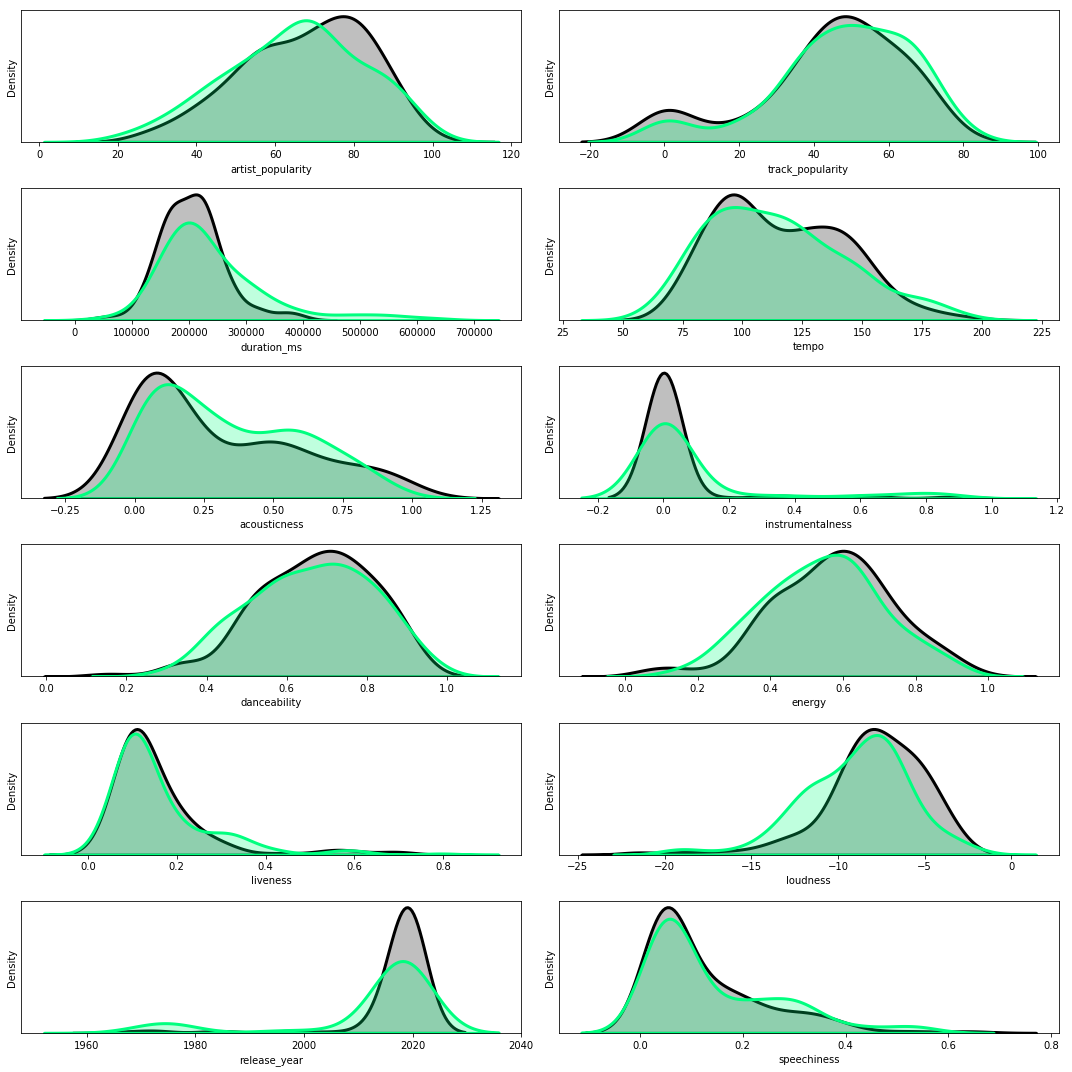

In [34]:
viz_feats = ['artist_popularity', 'track_popularity', 'duration_ms', 'tempo', 
             'acousticness', 'instrumentalness', 'danceability', 'energy',
             'liveness', 'loudness', 'release_year', 'speechiness']

f, axes = plt.subplots(6, 2, figsize=(15, 15), sharex=False)

for x in range(len(viz_feats)):
    sns.distplot(df_all.loc[(df_all['Liked'] == 0), viz_feats[x]], 
             color='black', hist=False, kde=True,
             kde_kws={'shade': True, 'linewidth': 3}, 
             label='Not Liked', ax=axes[m.floor(x/2), x%2])
    
    sns.distplot(df_all.loc[(df_all['Liked'] == 1), viz_feats[x]], 
             color='springgreen', hist=False, kde=True,
             kde_kws={'shade': True, 'linewidth': 3}, 
             label='Liked', ax=axes[m.floor(x/2), x%2])
    
plt.setp(axes, yticks=[])
plt.tight_layout()             

### *T-Test Example*

In [35]:
#Extract values for statistical testing

apop_liked = df_all.loc[(df_all['Liked'] == 1), "artist_popularity"]
apop_disliked = df_all.loc[(df_all['Liked'] == 0), "artist_popularity"]

#Execute t-test for significance
stats.ttest_ind(apop_liked, apop_disliked)

Ttest_indResult(statistic=-1.4064312741400238, pvalue=0.16063802726141313)

**_NOT SIGNIFICANT_** (P-value > .05)

In [36]:
#Extract values for statistical testing

tpop_liked = df_all.loc[(df_all['Liked'] == 1), "track_popularity"]
tpop_disliked = df_all.loc[(df_all['Liked'] == 0), "track_popularity"]

#Execute t-test for significance
stats.ttest_ind(tpop_liked, tpop_disliked)

Ttest_indResult(statistic=1.5236654681017843, pvalue=0.1286527831957829)

**_NOT SIGNIFICANT_** (P-value > .05)

In [37]:
#Extract values for statistical testing

duration_liked = df_all.loc[(df_all['Liked'] == 1), "duration_ms"]
duration_disliked = df_all.loc[(df_all['Liked'] == 0), "duration_ms"]

#Execute t-test for significance
stats.ttest_ind(duration_liked, duration_disliked)

Ttest_indResult(statistic=3.7625159616316086, pvalue=0.00020253047888847862)

**_SIGNIFICANT_** (P-value < .05)

# *Model Preparation*

### *Drop columns*

In [38]:
df_final = df_all.drop(["song", "song_id", "artist", "artist_id", "release_year", "decade"], axis=1)

#Move target feature to last
feature_order = [feature for feature in list(df_final.columns) if feature not in ["Liked"]] + ["Liked"]
df_final = df_final.loc[:, feature_order]
df_final.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,track_popularity,artist_popularity,song_age,decades_1960,decades_1970,decades_1980,decades_1990,decades_2000,decades_2010,decades_2020,time_signature_1,time_signature_3,time_signature_4,time_signature_5,Liked
0,0.0158,0.788,178907,0.491,0.802000,0.0824,-8.537,1,0.0516,119.992,0.724,1,0,0,0,0,0,0,0,0,0,0,0,0,62,4,0,0,0,0,0,1,0,0,0,1,0,1
1,0.0493,0.704,189554,0.594,0.000053,0.1320,-6.966,1,0.2110,78.585,0.296,0,0,1,0,0,0,0,0,0,0,0,0,47,75,4,0,0,0,0,0,1,0,0,0,1,0,1
2,0.8340,0.489,66133,0.624,0.347000,0.3250,-1.916,0,0.0344,167.108,0.574,0,0,0,0,1,0,0,0,0,0,0,0,65,71,2,0,0,0,0,0,1,0,0,0,1,0,1
3,0.7150,0.621,159400,0.461,0.001110,0.0929,-13.047,0,0.0735,88.034,0.122,1,0,0,0,0,0,0,0,0,0,0,0,55,84,0,0,0,0,0,0,0,1,0,0,1,0,1
4,0.0553,0.834,256613,0.591,0.000000,0.0740,-7.543,0,0.3050,104.944,0.900,0,0,0,0,0,0,0,0,0,0,1,0,55,67,2,0,0,0,0,0,1,0,0,0,1,0,1


### *Separate the data into X (features) and Y (target)*

In [39]:
#Feature values into X
X = df_final.iloc[:,:-1].values

#Target values into Y
Y = df_final.iloc[:,-1].values

### *Split the data into train and test sets*

In [40]:
#Split data into train and test sets, adjusted hyperparameters if necessary
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    random_state=0, 
                                                    test_size=0.3)
N = Y_test.size

# standardize features using scikit-learn
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# *Model Selection*

### *Classification Algorithms*

In [41]:
warnings.filterwarnings("ignore")
# Instantiate the various algorithms

# Logistic Regression

# --- Key Parameters ---
# C: the regularization strength (smaller values for greater regularization); default is 1.0
# l2 is the default penalty used for regularizartion;
#         l1 may be used for feature selection

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=1)

# Support Vector Machine

# --- Key Parameters ---
# C: how much penalty there is for misclassification (larger values for greater penalty); default is 1.0
# kernel: specifies the kernel type to be used (‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’); default is 'rbf'
# gamma: the coefficient for non-linear kernels (default is appox. 1/n_features)

from sklearn.svm import SVC
svm = SVC(C=1, kernel="rbf", gamma=.1)

# Random Forest (ensemble of Decision Trees)

# --- Key Parameters ---
# n_estimators: the number of trees in the forest; default is 10
# max_depth: the depth of the tree; defualt is None, full expansion

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10)

# k-Nearest Neighbor

# --- Key Parameters ---
# n_neighbors: number of neighbors to use; default is 5
# weights: weight function used; default is 'uniform'
        # 'uniform' means all points are weighted equally;
        # 'distance' means closer points have greater influence
        
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score 

#### Logistic Regression

LOGISTIC REGRESSION
Misclassified 42 out of 90
Accuracy: 0.53
training set score: 0.742857
test set score: 0.533333


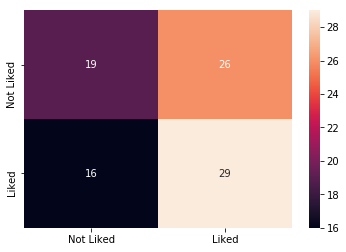

In [42]:
log_reg.fit(X_train_std, Y_train)
Y_pred = log_reg.predict(X_test_std)

print ("LOGISTIC REGRESSION")
print ("Misclassified {} out of {}".format( (Y_test != Y_pred).sum(), N))
print("Accuracy: %.2f" % accuracy_score(Y_test, Y_pred))
print("training set score: %f" % log_reg.score(X_train_std, Y_train))
print("test set score: %f" % log_reg.score(X_test_std, Y_test))

# CONFUSION MATRIX
plt.ylabel("Real value")
plt.xlabel("Predicted value")
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])

#### Support Vector Machine


SUPPORT VECTOR MACHINE
Misclassified 41 out of 90
Accuracy: 0.54
training set score: 0.942857
test set score: 0.544444


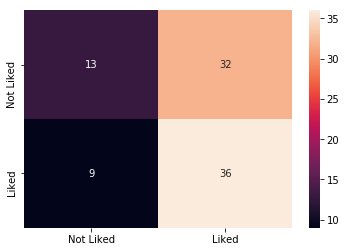

In [43]:
svm.fit(X_train_std, Y_train)
Y_pred = svm.predict(X_test_std)

print ("\nSUPPORT VECTOR MACHINE")
print ("Misclassified {} out of {}".format( (Y_test != Y_pred).sum(), N))
print("Accuracy: %.2f" % accuracy_score(Y_test, Y_pred))
print("training set score: %f" % svm.score(X_train_std, Y_train))
print("test set score: %f" % svm.score(X_test_std, Y_test))

# CONFUSION MATRIX
plt.ylabel("Real value")
plt.xlabel("Predicted value")
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])

#### Random Forest


RANDOM FOREST
Misclassified 41 out of 90
Accuracy: 0.54
training set score: 0.990476
test set score: 0.544444


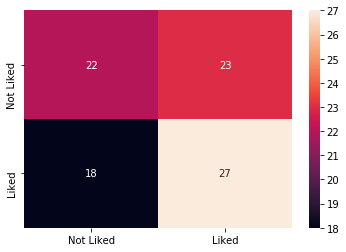

In [44]:
forest.fit(X_train_std, Y_train)
Y_pred = forest.predict(X_test_std)

print ("\nRANDOM FOREST")
print ("Misclassified {} out of {}".format( (Y_test != Y_pred).sum(), N))
print("Accuracy: %.2f" % accuracy_score(Y_test, Y_pred))
print("training set score: %f" % forest.score(X_train_std, Y_train))
print("test set score: %f" % forest.score(X_test_std, Y_test))

# CONFUSION MATRIX
plt.ylabel("Real value")
plt.xlabel("Predicted value")
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])

#### K-Nearnest Neighbors


RANDOM FOREST
Misclassified 45 out of 90
Accuracy: 0.50
training set score: 0.742857
test set score: 0.500000


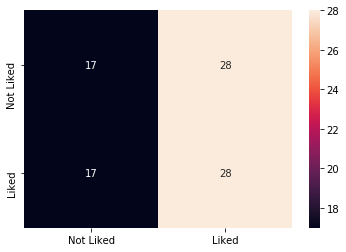

In [45]:
knn.fit(X_train_std, Y_train)
Y_pred = knn.predict(X_test_std)

print ("\nRANDOM FOREST")
print ("Misclassified {} out of {}".format( (Y_test != Y_pred).sum(), N))
print("Accuracy: %.2f" % accuracy_score(Y_test, Y_pred))
print("training set score: %f" % knn.score(X_train_std, Y_train))
print("test set score: %f" % knn.score(X_test_std, Y_test))

# CONFUSION MATRIX
plt.ylabel("Real value")
plt.xlabel("Predicted value")
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Not Liked', 'Liked'], yticklabels=['Not Liked', 'Liked'])

### *Cross Validation*

In [46]:
# 10-fold cross validation with a single algorithm

# scoring parameter: 'accuracy', 'precision', 'recall', ‘balanced_accuracy’

from sklearn.model_selection import cross_val_score
acc_scores = cross_val_score(log_reg, X_train_std, Y_train, scoring='accuracy', cv=10)
prec_scores = cross_val_score(log_reg, X_train_std, Y_train, scoring='precision', cv=10)
rec_scores = cross_val_score(log_reg, X_train_std, Y_train, scoring='recall', cv=10)

In [47]:
acc_scores, prec_scores, rec_scores

(array([0.72727273, 0.63636364, 0.54545455, 0.5       , 0.54545455,
        0.7       , 0.7       , 0.65      , 0.55      , 0.45      ]),
 array([0.75      , 0.66666667, 0.58333333, 0.54545455, 0.58333333,
        0.72727273, 0.77777778, 0.83333333, 0.58333333, 0.5       ]),
 array([0.75      , 0.66666667, 0.58333333, 0.5       , 0.58333333,
        0.72727273, 0.63636364, 0.45454545, 0.63636364, 0.63636364]))

In [48]:
acc_scores.mean(), prec_scores.mean(), rec_scores.mean()

(0.6004545454545455, 0.655050505050505, 0.6174242424242424)

# Evaluating Multiple Models

In [49]:
# 10-fold cross validation with a list of algorithms

classifiers = [log_reg, svm, forest, knn]

acc_model_scores, prec_model_scores, rec_model_scores = ([] for i in range(3))

for clf in classifiers:
    acc_model_scores.append(cross_val_score(clf, X_train_std, Y_train, scoring='accuracy', cv=10))
    prec_model_scores.append(cross_val_score(clf, X_train_std, Y_train, scoring='precision', cv=10))
    rec_model_scores.append(cross_val_score(clf, X_train_std, Y_train, scoring='recall', cv=10))

acc_model_scores

[array([0.72727273, 0.63636364, 0.54545455, 0.5       , 0.54545455,
        0.7       , 0.7       , 0.65      , 0.55      , 0.45      ]),
 array([0.59090909, 0.68181818, 0.77272727, 0.5       , 0.54545455,
        0.6       , 0.65      , 0.65      , 0.45      , 0.45      ]),
 array([0.59090909, 0.59090909, 0.68181818, 0.59090909, 0.59090909,
        0.3       , 0.5       , 0.75      , 0.45      , 0.5       ]),
 array([0.45454545, 0.68181818, 0.63636364, 0.54545455, 0.54545455,
        0.55      , 0.7       , 0.55      , 0.45      , 0.55      ])]

#### Accuracy

In [50]:
# use a DataFrame to view the cross validation results

acc_models_df = pd.DataFrame(acc_model_scores, columns=[1,2,3,4,5,6,7,8,9,10],
                             index=["LR", "SVM", "Forest", "KNN"])

prec_models_df = pd.DataFrame(prec_model_scores, columns=[1,2,3,4,5,6,7,8,9,10],
                              index=["LR", "SVM", "Forest", "KNN"])

rec_models_df = pd.DataFrame(rec_model_scores, columns=[1,2,3,4,5,6,7,8,9,10],
                             index=["LR", "SVM", "Forest", "KNN"])

acc_models_df["Mean"] = acc_models_df.mean(axis=1)
prec_models_df["Mean"] = acc_models_df.mean(axis=1)
rec_models_df["Mean"] = acc_models_df.mean(axis=1)

acc_models_df
#prec_models_df
#rec_models_df

,1,2,3,4,5,6,7,8,9,10,Mean
LR,0.727273,0.636364,0.545455,0.500000,0.545455,0.70,0.70,0.65,0.55,0.45,0.600455
SVM,0.590909,0.681818,0.772727,0.500000,0.545455,0.60,0.65,0.65,0.45,0.45,0.589091
Forest,0.590909,0.590909,0.681818,0.590909,0.590909,0.30,0.50,0.75,0.45,0.50,0.554545
KNN,0.454545,0.681818,0.636364,0.545455,0.545455,0.55,0.70,0.55,0.45,0.55,0.566364


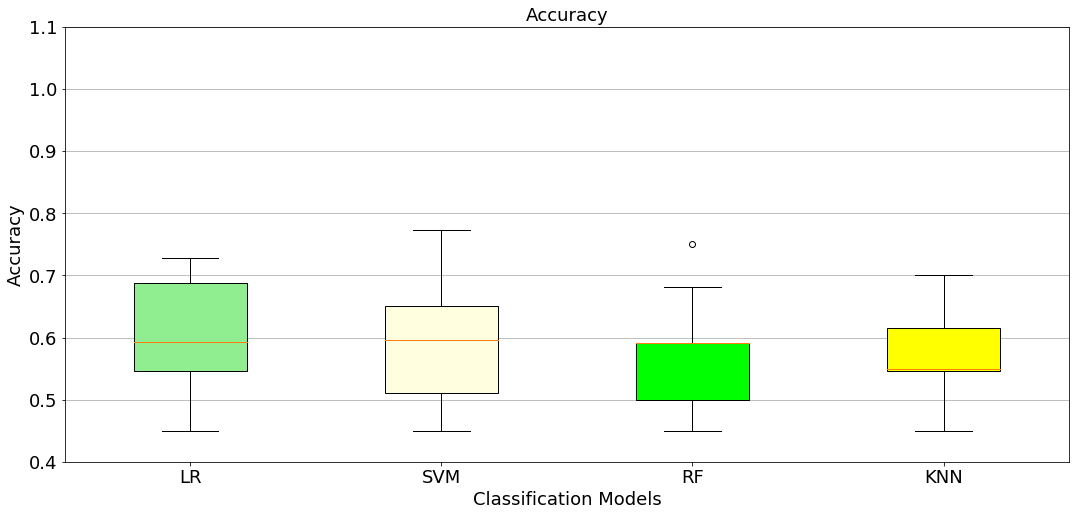

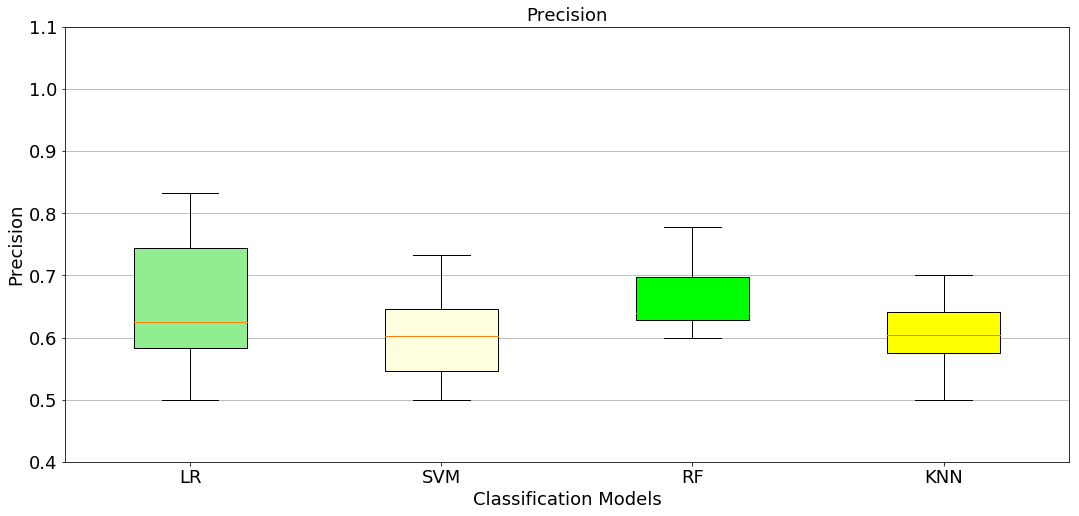

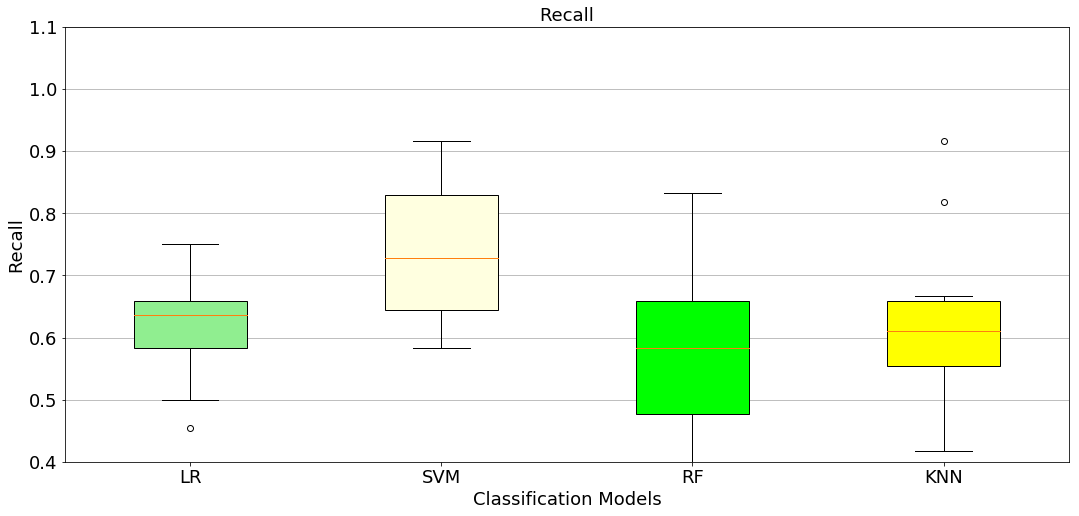

In [51]:
# BOXPLOT - visually comparing performance of the models

class_models = [acc_model_scores, prec_model_scores, rec_model_scores]
class_titles = ['Accuracy', 'Precision', 'Recall']

for model, title in zip(class_models, class_titles):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))

    # rectangular box plot
    # place the cross-validated model_scores list from above
    # into bplot_models here ------->
                               ##############
    bplot_models = axes.boxplot(model, vert=True, patch_artist=True)
                               ##############

    # fill with colors - Models
    colors_d = ["lightgreen", "lightyellow", "lime", "yellow"]
    for patch, color in zip(bplot_models['boxes'], colors_d):
        patch.set_facecolor(color)

    # adding axes labels
    axes.yaxis.grid(True)
    axes.set_xticks([y+1 for y in range(len(model))])
    axes.set_xlabel('Classification Models', fontsize=18)
    axes.set_ylabel(title, fontsize=18)
    axes.set_ylim((.4, 1.1))
    axes.set_title(title, fontsize=18)

    # add x-tick labels
    plt.setp(axes, xticks=[y+1 for y in range(len(model))],xticklabels=['LR', 'SVM', 'RF', 'KNN'])

    # increase tick size
    y_ticks = axes.get_yticklabels()
    x_ticks = axes.get_xticklabels()

    for x in x_ticks: 
        x.set_fontsize(18)       
    for y in y_ticks:
        y.set_fontsize(18)